<a href="https://colab.research.google.com/github/isikaykarakus/EmotionClassifier/blob/main/TurkishEmotionClassifier_SingleLabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Turkish Emotion Classifier**

This notebook aims to build a simple NLP pipeline that classifies Turkish text into emotions such as **happy**, **sadness**, **anger**, **fear**, and **disgust**.  
The dataset used is the **[TREMO (Turkish Emotion Dataset)](https://www.kaggle.com/datasets/mansuralp/tremo)**, which contains text entries collected from native Turkish speakers along with validated emotion labels.


# Load the Dataset

In [67]:
# Install Libraries (Optional, mostly pre-installed in Colab)
!pip install scikit-learn nltk pandas neattext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.8 MB/s eta 0:00:00


In [120]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pickle
import zipfile
import os
import neattext.functions as nfx # Load Text Cleaning Pkgs

In [43]:
# Unzip the file
zip_path = '/content/data.zip'
extract_path = '/content/data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [44]:
# check if the data unzipped
os.listdir(extract_path)


['paper_related_to_TREMO_dateset.pdf', 'TREMODATA.xml']

In [45]:
import xml.etree.ElementTree as ET

# Parse the XML
tree = ET.parse('/content/data/TREMODATA.xml')
root = tree.getroot()

# Print first few elements to see the structure of the data
for child in root[:5]:
    print(ET.tostring(child, encoding='unicode'))


<Doc>
    <ID>1</ID>
    <Entry>her yeni gün bir mutluluk</Entry>
    <OriginalEmotion>Happy</OriginalEmotion>
    <ValidatedEmotion>Happy</ValidatedEmotion>
    <Condition>Consensus</Condition>
    <VoteDistribution>
      <Emotion>Happy</Emotion>
      <Emotion>Happy</Emotion>
      <Emotion>Happy</Emotion>
    </VoteDistribution>
  </Doc>
  
<Doc>
    <ID>2</ID>
    <Entry>gece kimsenin olmadığı sokaklardan geçerken çok korkarım</Entry>
    <OriginalEmotion>Fear</OriginalEmotion>
    <ValidatedEmotion>Fear</ValidatedEmotion>
    <Condition>Consensus</Condition>
    <VoteDistribution>
      <Emotion>Fear</Emotion>
      <Emotion>Fear</Emotion>
      <Emotion>Fear</Emotion>
    </VoteDistribution>
  </Doc>
  
<Doc>
    <ID>3</ID>
    <Entry>gerçekleşemeyen hayaller</Entry>
    <OriginalEmotion>Anger</OriginalEmotion>
    <ValidatedEmotion>Sadness</ValidatedEmotion>
    <Condition>Consensus</Condition>
    <VoteDistribution>
      <Emotion>Sadness</Emotion>
      <Emotion>Sadness</Emot

In [47]:
# lists to hold the data
sentences = []
emotions = []

# Loop through each <Doc>
for doc in root.findall('Doc'):
    sentence = doc.find('Entry').text
    emotion = doc.find('ValidatedEmotion').text
    sentences.append(sentence)
    emotions.append(emotion)

# Create DataFrame
data = pd.DataFrame({
    'sentence': sentences,
    'emotion': emotions
})

# first 5 rows of the data
data.head()

,sentence,emotion
0,her yeni gün bir mutluluk,Happy
1,gece kimsenin olmadığı sokaklardan geçerken ço...,Fear
2,gerçekleşemeyen hayaller,Sadness
3,arkadaş kaybetmek beni üzüyor,Sadness
4,insanların çıkarcı olmalarından tiksiniyorum,Disgust


In [48]:
data

,sentence,emotion
0,her yeni gün bir mutluluk,Happy
1,gece kimsenin olmadığı sokaklardan geçerken ço...,Fear
2,gerçekleşemeyen hayaller,Sadness
3,arkadaş kaybetmek beni üzüyor,Sadness
4,insanların çıkarcı olmalarından tiksiniyorum,Disgust
...,...,...
27345,İnternet kotasının bitmesinden.,Ambigious
27346,Biri bana bir işi nasıl yapmam gerektiğini söy...,Anger
27347,Park halindeki arabama çarptıklarında.,Anger
27348,Bardağımı başkasının kullanması.,Disgust


The dataset contains 27350 entries with seven different emotions.





# Preprocessing the Data

In [62]:
# Value Counts
data['emotion'].value_counts()

,count
emotion,
Happy,5229
Sadness,5021
Anger,4723
Fear,4393
Disgust,3620
Surprise,3003
Ambigious,1361


<Axes: xlabel='emotion', ylabel='count'>

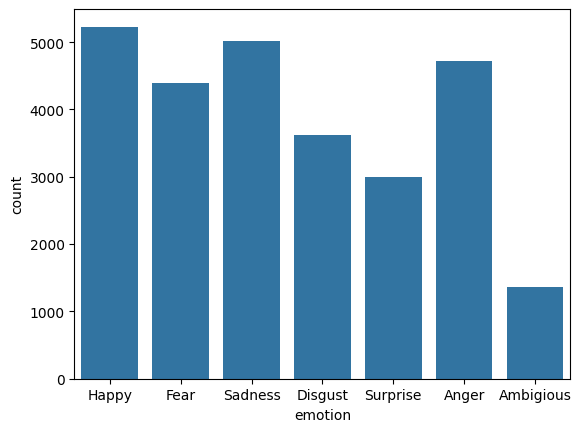

In [65]:
# Plot
sns.countplot(x='emotion',data=data)

In [72]:
# Data Cleaning
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

Challenge:
While using *nfx* (Neattext functions), it was not fully effective in removing all punctuation. Therefore, I added a manual punctuation removal step to improve the preprocessing.








In [103]:
# Load Turkish stopwords
turkish_stopwords = stopwords.words('turkish')

In [168]:
#  remove punctuation
def manual_remove_punctuation(text):
    return ''.join(char for char in text if char not in string.punctuation)

# preprocessing function
def preprocess(text):
    #  Lowercase
    text = text.lower()

    #  Remove punctuations
    text = nfx.remove_punctuations(text)
    text = manual_remove_punctuation(text)

    # remove stopwords
    text = ' '.join(word for word in text.split() if word not in turkish_stopwords)

    # remove numbers
    text = ''.join(word for word in text if not word.isdigit())

    # remove extra whitespaces
    text = ' '.join(text.split())

    return text

# Apply
data['clean_sentence'] = data['sentence'].apply(preprocess)
data.head()

,sentence,emotion,clean_sentence
0,her yeni gün bir mutluluk,Happy,yeni gün bir mutluluk
1,gece kimsenin olmadığı sokaklardan geçerken ço...,Fear,gece kimsenin olmadığı sokaklardan geçerken ko...
2,gerçekleşemeyen hayaller,Sadness,gerçekleşemeyen hayaller
3,arkadaş kaybetmek beni üzüyor,Sadness,arkadaş kaybetmek beni üzüyor
4,insanların çıkarcı olmalarından tiksiniyorum,Disgust,insanların çıkarcı olmalarından tiksiniyorum


## Feature Extraction and Model Training

Steps conducted:

- Features (`Xfeatures`) and labels (`labels`) are separated.
- Data is split into training and testing sets (70% / 30%).
- A Machine Learning Pipeline is created with:
  - `CountVectorizer()` for feature extraction
  - `LogisticRegression()` for classification
- The model is trained and evaluated.
- Achieved **82% accuracy** on the test set.

In [169]:
# Features & Labels
Xfeatures = data['clean_sentence']
ylabels = data['emotion']

In [170]:
#  Split Data
x_train,x_test,y_train,y_test = train_test_split(Xfeatures,ylabels,test_size=0.3,random_state=42)

In [171]:
# Logistic Regression Pipeline
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])

In [172]:
# Train and Fit Data
pipe_lr.fit(x_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [173]:
pipe_lr

Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [174]:
# Check Accuracy
pipe_lr.score(x_test,y_test)

0.8205971968312005

# Model Evaluation

The model's performance is evaluated using a confusion matrix and classification report. Overall, the model achieved **82% accuracy** on the test set.

- The model performs strongly across most emotion classes like Happy, Sadness, Fear, and Disgust.
- The **Ambiguous** class is challenging due to the unclear nature of these samples.
- The **Macro-Average F1-score** is **76%**, indicating solid balanced performance across all classes.


In [175]:
#Predict on Test Set
y_pred = pipe_lr.predict(x_test)

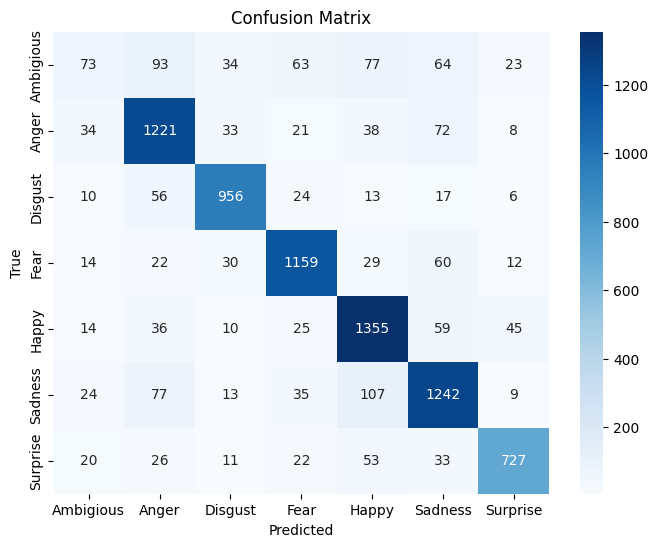

In [176]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pipe_lr.classes_, yticklabels=pipe_lr.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [177]:
# Create detailed report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Ambigious       0.39      0.17      0.24       427
       Anger       0.80      0.86      0.83      1427
     Disgust       0.88      0.88      0.88      1082
        Fear       0.86      0.87      0.87      1326
       Happy       0.81      0.88      0.84      1544
     Sadness       0.80      0.82      0.81      1507
    Surprise       0.88      0.82      0.84       892

    accuracy                           0.82      8205
   macro avg       0.77      0.76      0.76      8205
weighted avg       0.81      0.82      0.81      8205



In [178]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8205971968312005


#  Model Comparison: CountVectorizer vs TfidfVectorizer

Both `CountVectorizer` and `TfidfVectorizer` were evaluated using a Logistic Regression model:

- **CountVectorizer** achieved slightly higher overall performance (Accuracy: 82.17%, Macro F1: 76%).
- **TfidfVectorizer** achieved similar accuracy (82.00%) but slightly lower Macro F1-score (74%).

For this Turkish emotion classification task, `CountVectorizer` performs slightly better, likely because frequent words are **important** indicators of emotion classes.

by using this line of code:

> pipe_lr = Pipeline(steps=[('tfidf', TfidfVectorizer()),('lr', LogisticRegression())])





# Example

In [182]:
# Make A Prediction
ex1 = "Bu kitap çok şaşırtıcıydı, sonun böyle olması beni mutlu etti."

In [183]:
pipe_lr.predict([ex1])

array(['Happy'], dtype=object)

In [184]:
# Prediction Prob
pipe_lr.predict_proba([ex1])

array([[2.02331635e-03, 2.76314369e-04, 5.56604912e-05, 5.56695430e-04,
        9.94518217e-01, 1.89955054e-03, 6.70245377e-04]])

In [185]:
# Check classes
pipe_lr.classes_

array(['Ambigious', 'Anger', 'Disgust', 'Fear', 'Happy', 'Sadness',
       'Surprise'], dtype=object)

In [186]:
# Save Model & Pipeline
import joblib

os.makedirs('models', exist_ok=True)

# Save pipeline
joblib.dump(pipe_lr, "models/emotion_classifier_pipe_lr.pkl")

['models/emotion_classifier_pipe_lr.pkl']

In [187]:
# Load the saved pipeline
loaded_pipe = joblib.load("models/emotion_classifier_pipe_lr.pkl")

# More Examples

In [188]:
# Example Turkish sentences
sentences = [
    "Bugün hava çok güzel ve kendimi harika hissediyorum.",
    "Karanlık sokaklardan geçerken çok korktum.",
    "Arkadaşımın bana yalan söylemesi kalbimi kırdı.",
    "Herkes bana sürpriz yaptı, çok şaşırdım!",
    "İnsanların çıkarcı olması beni tiksindiriyor."
]

# Predict emotions
predictions = loaded_pipe.predict(sentences)

# Show results
for sentence, emotion in zip(sentences, predictions):
    print(f"Sentence: {sentence}\nPredicted Emotion: {emotion}\n")


Sentence: Bugün hava çok güzel ve kendimi harika hissediyorum.
Predicted Emotion: Happy

Sentence: Karanlık sokaklardan geçerken çok korktum.
Predicted Emotion: Fear

Sentence: Arkadaşımın bana yalan söylemesi kalbimi kırdı.
Predicted Emotion: Anger

Sentence: Herkes bana sürpriz yaptı, çok şaşırdım!
Predicted Emotion: Surprise

Sentence: İnsanların çıkarcı olması beni tiksindiriyor.
Predicted Emotion: Disgust



Some sentences may express multiple emotions (e.g., sadness and anger), as seen in the third example. However, the model is trained for single-label classification and must predict only the most dominant emotion based on the training data. In this case, "yalan söylemek" (telling a lie) is more strongly associated with Anger, which is why Anger is predicted as the dominant emotion.
Future improvements could include implementing multi-label classification or using stronger models such as BERT.


In [189]:
sentences = [
    "Benimle alaycı bir şekilde konuşması kalbimi kırdı, çok üzüldüm.",
    "Bana yalan söylediğine inanamıyorum, çok şaşkınım.",
    "onları birlikte görünce çok şaşırdım.",
    "beklenmedik bir anda karşılaştık."
]

# Predict emotions
predictions = loaded_pipe.predict(sentences)

# Show results
for sentence, emotion in zip(sentences, predictions):
    print(f"Sentence: {sentence}\nPredicted Emotion: {emotion}\n")

Sentence: Benimle alaycı bir şekilde konuşması kalbimi kırdı, çok üzüldüm.
Predicted Emotion: Sadness

Sentence: Bana yalan söylediğine inanamıyorum, çok şaşkınım.
Predicted Emotion: Anger

Sentence: onları birlikte görünce çok şaşırdım.
Predicted Emotion: Surprise

Sentence: beklenmedik bir anda karşılaştık.
Predicted Emotion: Surprise

